# Binarizable permutations

In [13]:
from rule import Rule
from symbol import is_nonterminal, is_terminal
from wcfg import FrozenWCFG, WCFG, count_derivations
from wfsa import WDFSA
from earley import Earley
from collections import defaultdict
import math
# config nx
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [17]:
def wcfg2nx(wcfg):
    
    # config child node
    def child_attrs(children, i):
        d = {'arrowhead': 'none', 'labeljust':'l'}
        if len(children) > 1:
            d['headlabel'] = str(i + 1)
        return d

    # build hypergraph
    r2i = {}
    graph = nx.DiGraph()
    e_attr = {'shape':'point', 'label':''}
    for parent, rules in wcfg.iteritems():
        print parent
        graph.add_node(parent)
        for rule in rules:
            e = r2i.get((parent, tuple(rule.rhs)), None)
            if e is None:
                e = 'e%d' % (len(r2i) + 1)
                r2i[(parent, rule.rhs)] = e
                graph.add_node(e, attr_dict={'shape':'point'})
                graph.add_edge(parent, e, attr_dict={'arrowhead':'none'})
                
            for i, child in enumerate(rule.rhs):
                graph.add_node(child)
                graph.add_edge(e, child, attr_dict=child_attrs(rule.rhs, i))
    return graph

In [2]:
def read_grammar_rules(istream, already_log=True):
    for line in istream:
        lhs, rhs, log_prob = line.strip().split(' ||| ')
        rhs = rhs.split()
        log_prob = float(log_prob)
        if not already_log:
            log_prob = math.log(log_prob)
        yield Rule(lhs, rhs, log_prob)

In [3]:
def make_linear_fsa(input_str):
    wfsa = WDFSA()
    tokens = input_str.split()
    for i, token in enumerate(tokens):
        wfsa.add_arc(i, i + 1, token)
    wfsa.make_initial(0)
    wfsa.make_final(len(tokens))
    return wfsa

In [4]:
def parse(wcfg, input_str):
    wfsa = make_linear_fsa(input_str)
    print 'FSA'
    print wfsa
    parser = Earley(wcfg, wfsa)
    status, R = parser.do('[S]', '[GOAL]')
    if not status:
        print 'NO PARSE FOUND'
        return False
    forest = WCFG()
    for rule in R:
        forest.add_rule(rule)
        #continue
        if len(rule.rhs) > 1 and all(map(is_nonterminal, rule.rhs)):
            forest.add_rule(Rule(rule.lhs, reversed(rule.rhs), rule.log_prob))
    print 'FOREST'
    print forest

    counts = count_derivations(forest, '[GOAL]')
    #for d, n in counts['d'].iteritems():
    #    print ' ||| '.join(str(r) for r in d), n
    total = 0
    print 'PERMUTATIONS'
    for p, n in sorted(counts['p'].iteritems(), key=lambda (k, v): k):
        print p, n
        total += n
    print len(counts['p'].keys()),'permutations and', total, 'derivations'
    return True

In [5]:
GRAMMAR = ['[S] ||| [X] ||| 1.0', '[X] ||| [X] [X] ||| 1.0'] + ['[X] ||| %d ||| 1.0' % i for i in range(1,10)]
wcfg = FrozenWCFG(read_grammar_rules(GRAMMAR, already_log=False))
print 'GRAMMAR'
print wcfg



GRAMMAR
[S] -> [X] (0.0)
[X] -> 2 (0.0)
[X] -> 4 (0.0)
[X] -> 9 (0.0)
[X] -> 5 (0.0)
[X] -> 6 (0.0)
[X] -> 1 (0.0)
[X] -> [X] [X] (0.0)
[X] -> 8 (0.0)
[X] -> 3 (0.0)
[X] -> 7 (0.0)


In [6]:
parse(wcfg, '1 2 3 4')

FSA
(1, 2, 2, 0.0)
(0, 1, 1, 0.0)
(3, 4, 4, 0.0)
(2, 3, 3, 0.0)
FOREST
[X,0-1] -> 1 (0.0)
[GOAL] -> [S,0-4] (0.0)
[X,1-4] -> [X,1-3] [X,3-4] (0.0)
[X,1-4] -> [X,3-4] [X,1-3] (0.0)
[X,1-4] -> [X,1-2] [X,2-4] (0.0)
[X,1-4] -> [X,2-4] [X,1-2] (0.0)
[X,3-4] -> 4 (0.0)
[X,0-3] -> [X,0-2] [X,2-3] (0.0)
[X,0-3] -> [X,2-3] [X,0-2] (0.0)
[X,0-3] -> [X,0-1] [X,1-3] (0.0)
[X,0-3] -> [X,1-3] [X,0-1] (0.0)
[X,0-2] -> [X,0-1] [X,1-2] (0.0)
[X,0-2] -> [X,1-2] [X,0-1] (0.0)
[S,0-4] -> [X,0-4] (0.0)
[X,1-2] -> 2 (0.0)
[X,1-3] -> [X,1-2] [X,2-3] (0.0)
[X,1-3] -> [X,2-3] [X,1-2] (0.0)
[X,2-3] -> 3 (0.0)
[X,0-4] -> [X,0-2] [X,2-4] (0.0)
[X,0-4] -> [X,2-4] [X,0-2] (0.0)
[X,0-4] -> [X,0-3] [X,3-4] (0.0)
[X,0-4] -> [X,3-4] [X,0-3] (0.0)
[X,0-4] -> [X,0-1] [X,1-4] (0.0)
[X,0-4] -> [X,1-4] [X,0-1] (0.0)
[X,2-4] -> [X,2-3] [X,3-4] (0.0)
[X,2-4] -> [X,3-4] [X,2-3] (0.0)
PERMUTATIONS
('1', '2', '3', '4') 5
('1', '2', '4', '3') 2
('1', '3', '2', '4') 2
('1', '3', '4', '2') 1
('1', '4', '2', '3') 1
('1', '4', '3', 

True

In [18]:
G = wcfg2nx(wcfg)

[S]
[X]


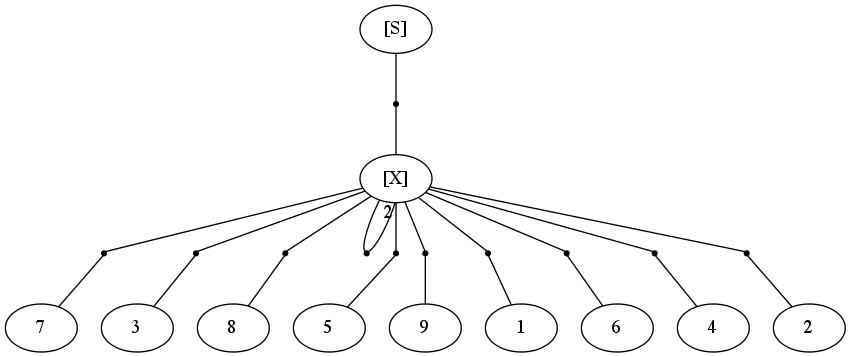

In [16]:
draw(G)

In [19]:
parse?